# RC Reservoir Computing

In [1]:
%matplotlib inline

In [2]:
from __future__ import division

In [3]:
import numpy as np
import scipy as sp
import scipy.integrate as spint
import matplotlib.pyplot as plt
import memristive_reservoir as memres
import numpy.random as nprand
from sklearn.linear_model import Ridge

Thusfar, the below investigations indicate that RC networks perform very well on the memory task but results are more measured on forecasting and nonlinear reconstruction, both tasks that require nonlinearity. In all cases tested, RC acts as a single timescale and so it seems the tuning can likely be simplified to only depend on a single parameter.  In these cases I use exponentially distributed R and C values but the Schrauwens paper indicates that best results are obtained with eigenvalues on a circle.  I think that inductors would be required to make this a possibility and am investigating this at the moment.

Note that for the first fitting task, we obtain arbitrary accuracy as $RC\to 0$.  This is because in that limit we are just reading the voltage generator output directly.  The memory reconsruction tasks give a more meaningful characterization of the network performance.

## Network Structures

In [4]:
# Two Network structures of interest are a mean-field like ER graph
# and a planar graph.  Inputs are weighted by a random vector.

n = 36
p = 0.16

Adj_ER = memres.create_adj_ER_G(n, p)

B_ER = memres.incidence(Adj_ER)
m_ER = B_ER.shape[1]

v_input_ER = np.random.rand(m_ER)
v0_ER = np.random.rand(m_ER)

# Gives a network of approximately 100 memristors
# A 8x8 cubic lattice will give a comparable network
# size.  Note that the boundaries are not periodic

lattice_shape = (8, 8)

Adj_cubic = memres.create_adj_cubic_2d(lattice_shape, undirected=False, xbias=0.5, ybias=0.5)
B_cubic = memres.incidence(Adj_cubic)
m_cubic = B_cubic.shape[1]

v_input_cubic = np.random.rand(m_cubic)
v0_cubic = np.random.rand(m_cubic)



## Signal Construction

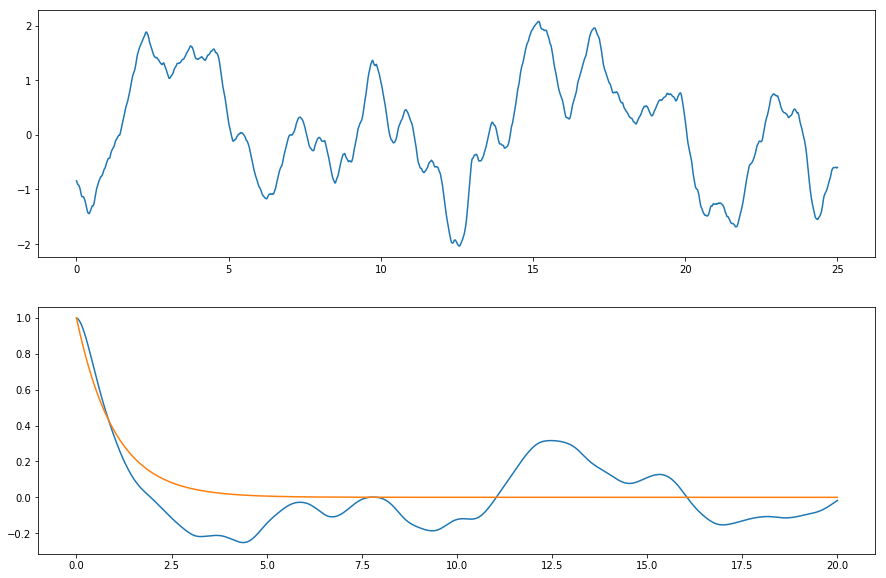

In [28]:
# We can generate noise with an approximate autocorrelation
# function by filtering delta correlated gaussian noise.
# We generate the gaussian noise on a timescale much faster
# than our filter.

# The signal is normalized to have an autocorrelation R(0) = 1
# We can see that the 2-sided exponential filter must hav a timescale
# of t/2 to give an autocorrelation with a timescale of t

t_final = 25

tstep_fast = 1e-3
N_tsteps = int(t_final / tstep_fast)+1

noise_times = np.linspace(0, t_final, N_tsteps)
source_noise = np.random.randn(N_tsteps)

exp_filter = np.concatenate((np.flipud(np.exp(-2*noise_times)), np.exp(-2*noise_times)))



filtered_noise = np.array([np.dot(exp_filter[i:i+N_tsteps], source_noise)*tstep_fast for i in range(N_tsteps)])

#We can downsample to a timescale 10x faster than the filter
DS = 10
filtered_noise = filtered_noise[::DS]
noise_times = noise_times[::DS]
tstep_ds = DS*tstep_fast
N_times = len(filtered_noise)

noise_variance = np.dot(filtered_noise, filtered_noise)/N_times
filtered_noise = filtered_noise / np.sqrt(noise_variance)

def noise_func(t):
    return np.interp(t, noise_times, filtered_noise)

def noise_func_ER(t):
    return v_input_ER * noise_func(t)

def noise_func_cubic(t):
    return v_input_cubic * noise_func(t)

overlap = int(N_times/5)

auto_corr = np.array([np.dot(filtered_noise[:i], filtered_noise[-i:])/N_times for i in range(overlap, N_times)])
auto_corr = np.flipud(auto_corr)
auto_corr_times = tstep_ds* np.arange(N_times-overlap)

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(noise_times, filtered_noise)
ax[1].plot(auto_corr_times, auto_corr)
ax[1].plot(auto_corr_times, np.exp(-1*auto_corr_times))

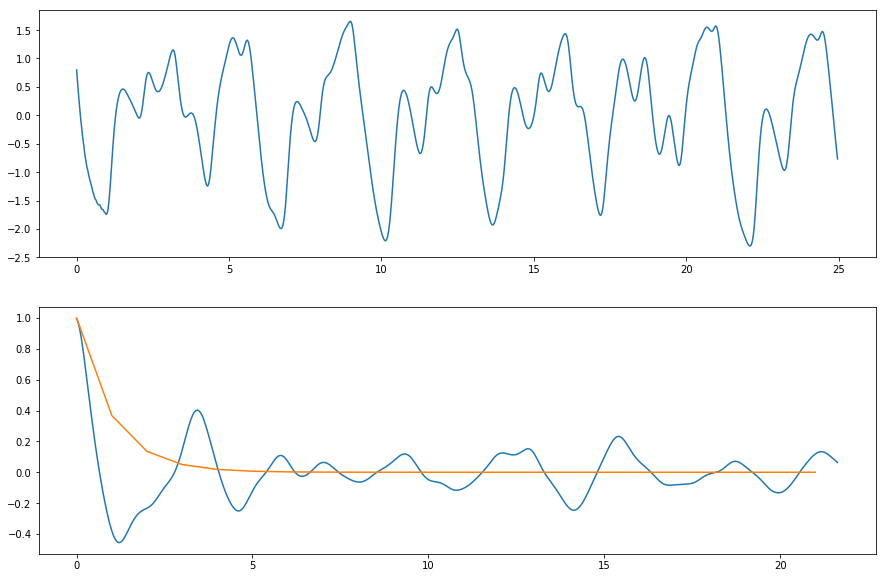

In [29]:
# The Mackey glass is a nonlinear delay differential equation.  After generating
# the data is centered and the variance normalized to 1.  The timescale is adjusted
# such that the autocorrelation function has a timescale of approx. 1.  If parameters
# of the simulation are changed, the timescale also has to be adjusted.

import collections
import numpy as np


def mackey_glass(time, dt, tau=30, seed=None):
    '''
    mackey_glass(sample_len=1000, tau=17, seed = None, n_samples = 1) -> input
    Generate the Mackey Glass time-series. Parameters are:
        - time: the number of timesteps
        - tau: delay of the MG - system. Commonly used values are tau=17 (mild 
          chaos) and tau=30 (moderate chaos). Default is 17.
        - seed: to seed the random generator, can be used to generate the same
          timeseries at each invocation.
    '''

    history_len = int(tau / dt)
    # Initial conditions for the history of the system
    timeseries = 1.2
    
    if seed is not None:
        np.random.seed(seed)


    history = collections.deque(1.2 * np.ones(history_len) + 0.2 * \
                                (np.random.rand(history_len) - 0.5))
    # Preallocate the array for the time-series
    inp = np.zeros((time,))
        
    for timestep in range(time):
        for _ in range(int(1/dt)):
            xtau = history.popleft()
            history.append(timeseries)
            timeseries = history[-1] + (0.2 * xtau / (1.0 + xtau ** 10) - \
                            0.1 * history[-1]) * dt
        inp[timestep] = timeseries

    return inp

time = 750

t_scale = 30
mg_series = mackey_glass(time, 0.1)

mg_series = mg_series - np.mean(mg_series)
variance = np.dot(mg_series, mg_series)/len(mg_series)
mg_series = mg_series/np.sqrt(variance)

mg_times = np.arange(time)/t_scale

def MG_func(t):
    return np.interp(t, mg_times, mg_series)

def MG_func_ER(t):
    return v_input_ER*MG_func(t)

def MF_func_cubic(t):
    return v_input_cubic*MG_func(t)

overlap=100


auto_corr = np.array([np.dot(mg_series[:i], mg_series[-i:])/time for i in range(overlap, time)])
auto_corr = np.flipud(auto_corr)
auto_corr_times = np.arange(time-overlap)/t_scale

fig, ax = plt.subplots(2, 1, figsize=(15, 10))

ax[0].plot(mg_times, mg_series)
ax[1].plot(auto_corr_times, auto_corr)
ax[1].plot(np.arange((time-overlap)/t_scale), np.exp(-np.arange((time-overlap)/t_scale)))

## Network Simulations

The equation for a network of links containing capacitors in parallel with a resistor voltage generator link is,
$$ \frac{d\vec{v}}{dt} = -B^T(BCB^T)^{-1}R^{-1}(\vec{v} - \vec{s}(t))$$
where $B$ is the incidence matrix, and $C, R$ are diagonal matrices containing the capacitance and resistance respectively.

In [11]:
# # Added to memristive_reservoir.py

# import scipy.linalg as linalg

# def RCEqn(source, B, R, C):
#     '''
#     R and C are vectors
#     '''
#     BCBt = linalg.inv(np.einsum('ij,jk,lk', B, np.diag(C), B))
#     BtBCBtBR = np.einsum('ji,jk,kl,lm', B, BCBt, B, np.diag(1/R))
#     def dvdt(t, v):
        
#         deriv = np.dot(BtBCBtBR, (source(t) - v))
#         return deriv
#     return dvdt

# def integrate_RC(dvdt, t_interval, v0):
#     m = v0.shape[0]
#     t, t_final = t_interval
    
#     times = np.array([0])
#     sol = spint.solve_ivp(dvdt, t_interval, v0, max_step=0.05)
    
#     return sol.t, sol.y


In [12]:
R = np.ones(m_ER)
C = np.ones(m_ER)
dvdt = RCEqn(noise_func, B_ER, R, C)

tfinal=25

times, traj = integrate_RC(dvdt, (0, tfinal), v0_ER)

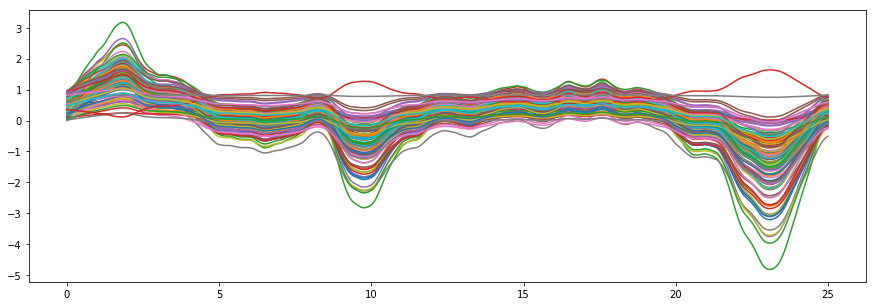

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))

for idx in range(m_ER):
    ax.plot(times, traj[idx, :])

In [16]:
# Encapsulating the Training Procedure

def train_RC_reservoir(source, output_func, B, R, C, t_final=25, transient=10, training_tfinal=20, plotting=True):
    '''
    Performs the simulation and fitting of a reservoir, returning
    the simulated trajectory, trained regressor, and
    MSE of the training and extrapolation
    '''
    m = B.shape[1]
    
    dvdt = memres.RCEqn(source, B, R, C)
    times, traj = memres.integrate_RC(dvdt, (0, t_final), np.random.rand(m))
    
    training_mask = np.logical_and(times > transient, times < training_tfinal)
    training_times = times[training_mask]
    training_traj = traj[:, training_mask]
    training_output = output_func(training_times)

    clf = Ridge(alpha=0.001)
    clf.fit(training_traj.T, training_output)
    reconstruction = clf.predict(training_traj.T)
    
    MSE_train = MSE_reservoir(training_output, reconstruction, training_times)
    
    extrap_mask = times >= training_tfinal
    extrap_times = times[extrap_mask]
    extrap_traj = traj[:, extrap_mask]
    
    extrap_output = output_func(extrap_times)
    extrapolation = clf.predict(extrap_traj.T)
    
    MSE_extrap = MSE_reservoir(extrap_output, extrapolation, extrap_times)
    
    if plotting:
        fig, ax = plt.subplots(2, 1, figsize=(15, 10))
        for idx in range(m):
            ax[0].plot(times, traj[idx, :])
        ax[1].plot(training_times, training_output)
        ax[1].plot(training_times, reconstruction)
        ax[1].plot(extrap_times, extrap_output)
        ax[1].plot(extrap_times, extrapolation)
        
    return times, traj, clf, MSE_train, MSE_extrap

In [18]:
def MSE_reservoir(training_data, reconstruction, times):
    T = times[-1] - times[0]
    dt = times[1:] - times[:-1]
    squared_error = (reconstruction - training_data)**2
    squared_error_symm = (squared_error[:-1] + squared_error[1:])/2
    return np.dot(squared_error_symm, dt)/T

Training MSE: 0.00204132759556
Extrapolated MSE: 0.0113880143328


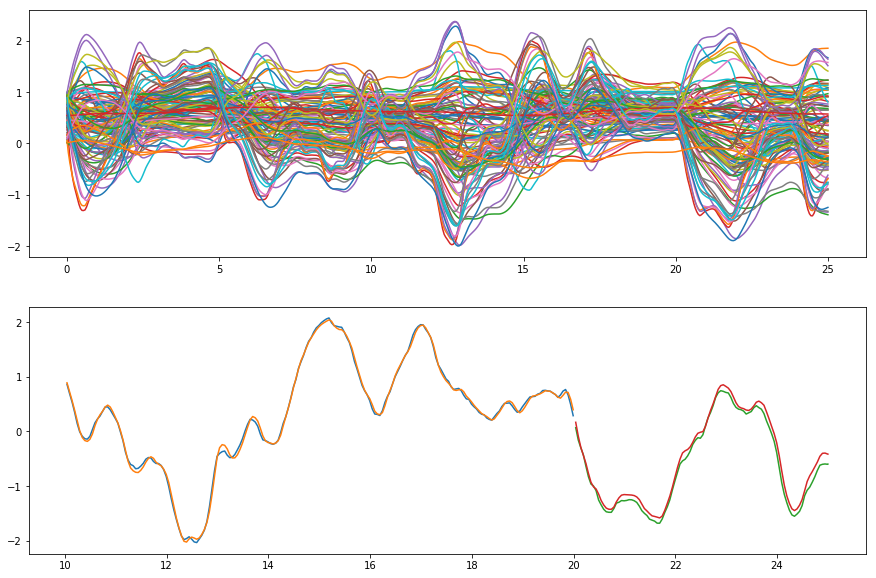

In [34]:
R = np.random.exponential(scale=1, size=m_cubic)
C = np.random.exponential(scale=8, size=m_cubic)



times, traj, clf, MSE_train, MSE_extrap = train_RC_reservoir(noise_func, 
                                            noise_func, B_cubic, R, C)

print "Training MSE:", str(MSE_train)
print "Extrapolated MSE:", str(MSE_extrap)

## Tuning $R$, $C$

In [35]:

R_list = [0.1, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
num_R = len(R_list)
C_list = [0.1, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
num_C = len(C_list)

MSE_training_tuning = np.zeros((num_R, num_C), dtype='float')
MSE_extrap_tuning = np.zeros((num_R, num_C), dtype='float')

for R_idx, R_scale in enumerate(R_list):
    for C_idx, C_scale in enumerate(C_list):

            
        R = np.random.exponential(scale=R_scale, size=(m_cubic,))
        C = np.random.exponential(scale=C_scale, size=(m_cubic,))

        times, traj, clf, MSE_training, MSE_extrap = train_RC_reservoir(noise_func_cubic, 
                                            noise_func, B_cubic, R, C, plotting=False)

        MSE_training_tuning[R_idx, C_idx] = MSE_training
        MSE_extrap_tuning[R_idx, C_idx] = MSE_extrap

np.savez('MSE_parameter_sweep_RC_ER_filterednoise_expanded', R_list, C_list, MSE_training_tuning, MSE_extrap_tuning)

In [36]:
files = np.load('MSE_parameter_sweep_RC_ER_filterednoise_expanded.npz')

R_list = files['arr_0']
C_list = files['arr_1']
MSE_training_tuning = files['arr_2']
MSE_extrap_tuning = files['arr_3']

Text(0.5,0.92,'$\\ln(MSE)$ extrap')

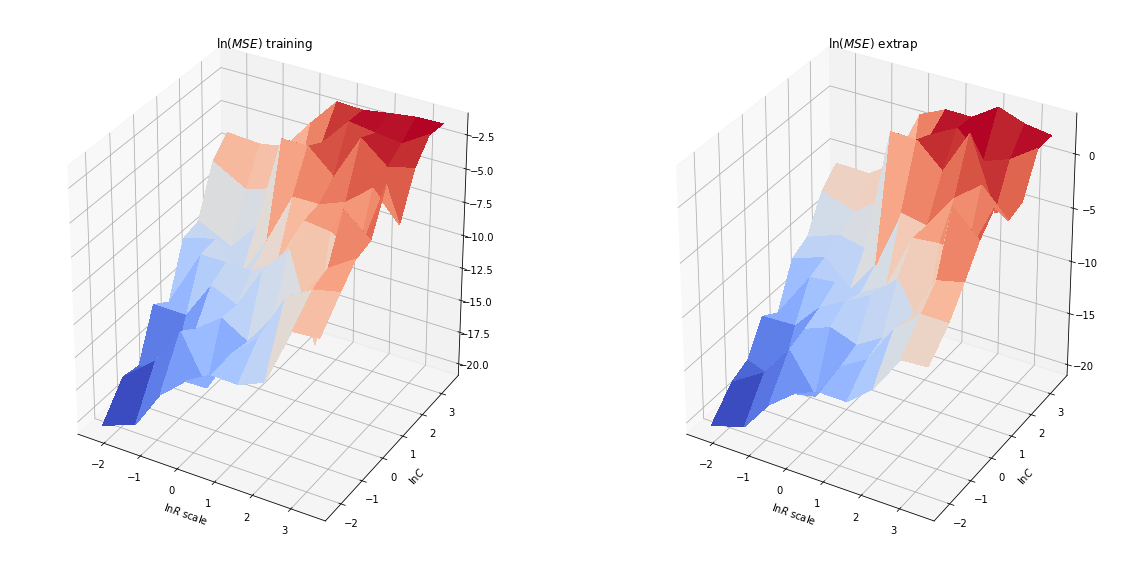

In [42]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(20, 10))

rr, cc = np.meshgrid(R_list, C_list)

ax = fig.add_subplot(121, projection='3d')
    
surf = ax.plot_surface(np.log(rr), np.log(cc), np.log(MSE_training_tuning.T), rstride=1, cstride=1,
                        cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel(r'$\ln R$ scale')

ax.set_ylabel(r'$\ln C$')
ax.set_title(r'$\ln(MSE)$ training' )
    
#ax.view_init(azim=90)
             
ax = fig.add_subplot(122, projection='3d')
    
surf = ax.plot_surface(np.log(rr), np.log(cc), np.log(MSE_extrap_tuning.T), rstride=1, cstride=1,
                        cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel(r'$\ln R$ scale')

ax.set_ylabel(r'$\ln C$')
ax.set_title(r'$\ln(MSE)$ extrap')
    
#ax.view_init(azim=90)

As this is just reconstruction of the input signal and the network is linear we are likely just reading teh input signal directly.  Indeed, as $RC\to 0$ the voltage of a link is just that of the voltage generator.  We must look at memory or forcasting for a more meaningful test.

Training MSE: 6.3861534286e-10
Extrapolated MSE: 6.07174814339e-10


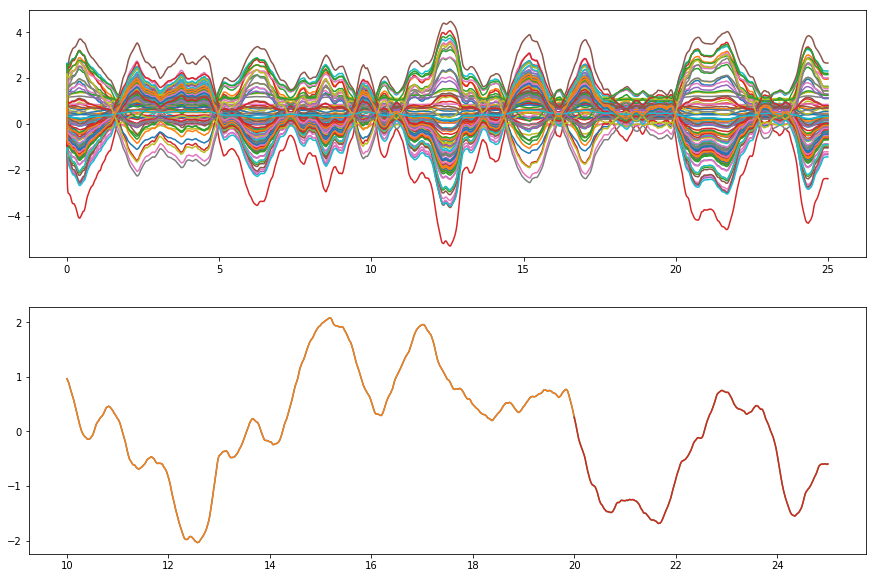

In [43]:
R = np.random.exponential(scale=0.1, size=m_cubic)
C = np.random.exponential(scale=0.1, size=m_cubic)



times, traj, clf, MSE_train, MSE_extrap = train_RC_reservoir(noise_func, 
                                            noise_func, B_cubic, R, C)

print "Training MSE:", str(MSE_train)
print "Extrapolated MSE:", str(MSE_extrap)

## Tuning for Memory

In [45]:

R_list = [0.1, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
num_R = len(R_list)
C_list = [0.1, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
num_C = len(C_list)

MSE_training_tuning = np.zeros((num_R, num_C), dtype='float')
MSE_extrap_tuning = np.zeros((num_R, num_C), dtype='float')

tau = 1.
def delayed_noise(t):
    return noise_func(t-tau)

for R_idx, R_scale in enumerate(R_list):
    for C_idx, C_scale in enumerate(C_list):

            
        R = np.random.exponential(scale=R_scale, size=(m_cubic,))
        C = np.random.exponential(scale=C_scale, size=(m_cubic,))

        times, traj, clf, MSE_training, MSE_extrap = train_RC_reservoir(noise_func_cubic, 
                                            delayed_noise, B_cubic, R, C, plotting=False)

        MSE_training_tuning[R_idx, C_idx] = MSE_training
        MSE_extrap_tuning[R_idx, C_idx] = MSE_extrap

np.savez('MSE_parameter_sweep_RC_ER_filterednoise_delay1', R_list, C_list, MSE_training_tuning, MSE_extrap_tuning)

In [46]:
files = np.load('MSE_parameter_sweep_RC_ER_filterednoise_delay1.npz')

R_list = files['arr_0']
C_list = files['arr_1']
MSE_training_tuning = files['arr_2']
MSE_extrap_tuning = files['arr_3']

Text(0.5,0.92,'$\\ln(MSE)$ extrap')

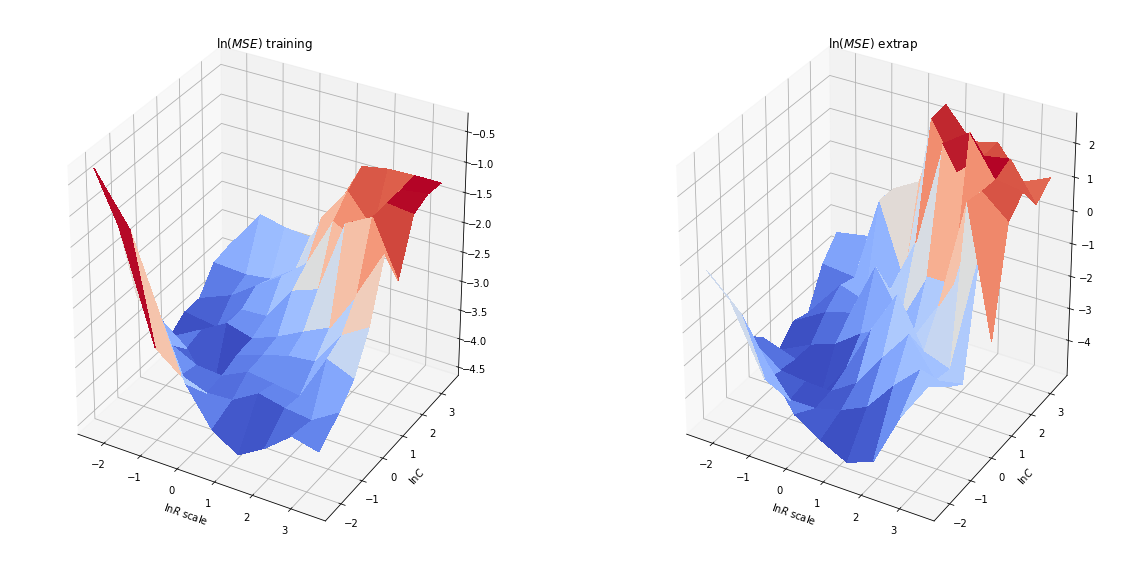

In [47]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(20, 10))

rr, cc = np.meshgrid(R_list, C_list)

ax = fig.add_subplot(121, projection='3d')
    
surf = ax.plot_surface(np.log(rr), np.log(cc), np.log(MSE_training_tuning.T), rstride=1, cstride=1,
                        cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel(r'$\ln R$ scale')

ax.set_ylabel(r'$\ln C$')
ax.set_title(r'$\ln(MSE)$ training' )
    
#ax.view_init(azim=90)
             
ax = fig.add_subplot(122, projection='3d')
    
surf = ax.plot_surface(np.log(rr), np.log(cc), np.log(MSE_extrap_tuning.T), rstride=1, cstride=1,
                        cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel(r'$\ln R$ scale')

ax.set_ylabel(r'$\ln C$')
ax.set_title(r'$\ln(MSE)$ extrap')
    
#ax.view_init(azim=90)

### Tuning for Mackey Glass Forcasting

In [51]:
R_list = [0.1, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
num_R = len(R_list)
C_list = [0.1, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
num_C = len(C_list)

MSE_training_tuning = np.zeros((num_R, num_C), dtype='float')
MSE_extrap_tuning = np.zeros((num_R, num_C), dtype='float')

tau = 0.25
def forcasted_MG(t):
    return MG_func(t+tau)

for R_idx, R_scale in enumerate(R_list):
    for C_idx, C_scale in enumerate(C_list):

            
        R = np.random.exponential(scale=R_scale, size=(m_cubic,))
        C = np.random.exponential(scale=C_scale, size=(m_cubic,))

        times, traj, clf, MSE_training, MSE_extrap = train_RC_reservoir(noise_func_cubic, 
                                            forcasted_MG, B_cubic, R, C, plotting=False)

        MSE_training_tuning[R_idx, C_idx] = MSE_training
        MSE_extrap_tuning[R_idx, C_idx] = MSE_extrap

np.savez('MSE_parameter_sweep_RC_ER_filterednoise_forecast0.25', R_list, C_list, MSE_training_tuning, MSE_extrap_tuning)

Text(0.5,0.92,'$\\ln(MSE)$ extrap')

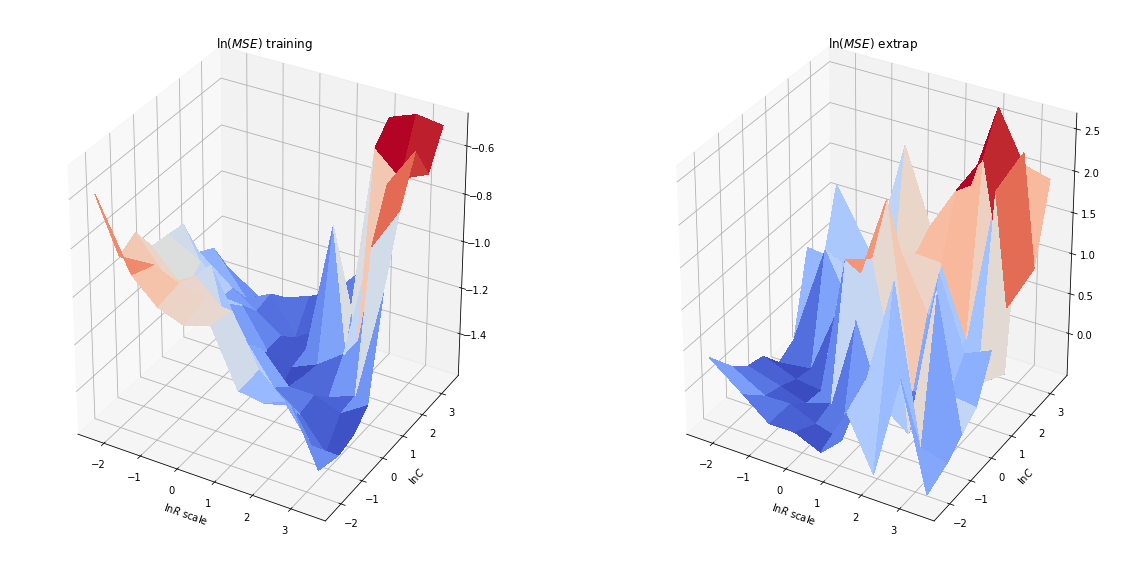

In [55]:
files = np.load('MSE_parameter_sweep_RC_ER_filterednoise_forecast0.25.npz')

R_list = files['arr_0']
C_list = files['arr_1']
MSE_training_tuning = files['arr_2']
MSE_extrap_tuning = files['arr_3']

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(20, 10))

rr, cc = np.meshgrid(R_list, C_list)

ax = fig.add_subplot(121, projection='3d')
    
surf = ax.plot_surface(np.log(rr), np.log(cc), np.log(MSE_training_tuning.T), rstride=1, cstride=1,
                        cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel(r'$\ln R$ scale')

ax.set_ylabel(r'$\ln C$')
ax.set_title(r'$\ln(MSE)$ training' )
    
#ax.view_init(azim=90)
             
ax = fig.add_subplot(122, projection='3d')
    
surf = ax.plot_surface(np.log(rr), np.log(cc), np.log(MSE_extrap_tuning.T), rstride=1, cstride=1,
                        cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel(r'$\ln R$ scale')

ax.set_ylabel(r'$\ln C$')
ax.set_title(r'$\ln(MSE)$ extrap')
    
#ax.view_init(azim=90)

### Tuning for Noise Forecasting

In [60]:
R_list = [0.1, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
num_R = len(R_list)
C_list = [0.1, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
num_C = len(C_list)

MSE_training_tuning = np.zeros((num_R, num_C), dtype='float')
MSE_extrap_tuning = np.zeros((num_R, num_C), dtype='float')

tau = 0.25
def forecasted_noise(t):
    return noise_func(t+tau)

for R_idx, R_scale in enumerate(R_list):
    for C_idx, C_scale in enumerate(C_list):

            
        R = np.random.exponential(scale=R_scale, size=(m_cubic,))
        C = np.random.exponential(scale=C_scale, size=(m_cubic,))

        times, traj, clf, MSE_training, MSE_extrap = train_RC_reservoir(noise_func_cubic, 
                                            forecasted_noise, B_cubic, R, C, plotting=False)

        MSE_training_tuning[R_idx, C_idx] = MSE_training
        MSE_extrap_tuning[R_idx, C_idx] = MSE_extrap

np.savez('MSE_parameter_sweep_RC_ER_filterednoise_forecast0.25', R_list, C_list, MSE_training_tuning, MSE_extrap_tuning)

Text(0.5,0.92,'$\\ln(MSE)$ extrap')

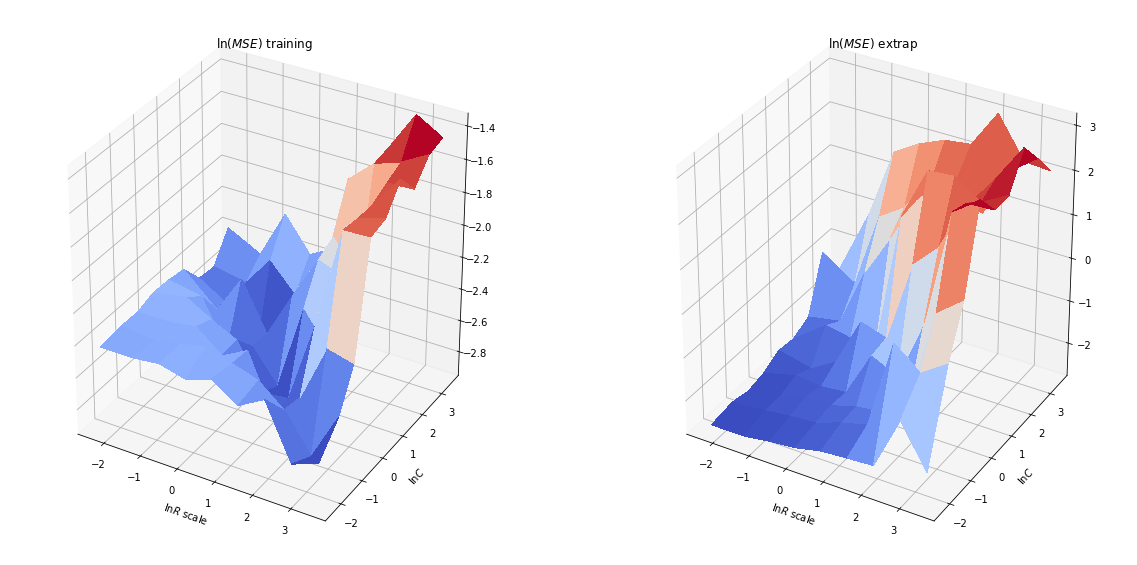

In [61]:
files = np.load('MSE_parameter_sweep_RC_ER_filterednoise_forecast0.25.npz')

R_list = files['arr_0']
C_list = files['arr_1']
MSE_training_tuning = files['arr_2']
MSE_extrap_tuning = files['arr_3']

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(20, 10))

rr, cc = np.meshgrid(R_list, C_list)

ax = fig.add_subplot(121, projection='3d')
    
surf = ax.plot_surface(np.log(rr), np.log(cc), np.log(MSE_training_tuning.T), rstride=1, cstride=1,
                        cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel(r'$\ln R$ scale')

ax.set_ylabel(r'$\ln C$')
ax.set_title(r'$\ln(MSE)$ training' )
    
#ax.view_init(azim=90)
             
ax = fig.add_subplot(122, projection='3d')
    
surf = ax.plot_surface(np.log(rr), np.log(cc), np.log(MSE_extrap_tuning.T), rstride=1, cstride=1,
                        cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel(r'$\ln R$ scale')

ax.set_ylabel(r'$\ln C$')
ax.set_title(r'$\ln(MSE)$ extrap')
    
#ax.view_init(azim=90)

### Tuning for Nonlinear Reconstruction

In [58]:
R_list = [0.1, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
num_R = len(R_list)
C_list = [0.1, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
num_C = len(C_list)

MSE_training_tuning = np.zeros((num_R, num_C), dtype='float')
MSE_extrap_tuning = np.zeros((num_R, num_C), dtype='float')

freq=2.0
def sin_noise(t):
    return np.sin(freq*noise_func(t))

for R_idx, R_scale in enumerate(R_list):
    for C_idx, C_scale in enumerate(C_list):

            
        R = np.random.exponential(scale=R_scale, size=(m_cubic,))
        C = np.random.exponential(scale=C_scale, size=(m_cubic,))

        times, traj, clf, MSE_training, MSE_extrap = train_RC_reservoir(noise_func_cubic, 
                                            sin_noise, B_cubic, R, C, plotting=False)

        MSE_training_tuning[R_idx, C_idx] = MSE_training
        MSE_extrap_tuning[R_idx, C_idx] = MSE_extrap

np.savez('MSE_parameter_sweep_RC_ER_filterednoise_sin2', R_list, C_list, MSE_training_tuning, MSE_extrap_tuning)

Text(0.5,0.92,'$\\ln(MSE)$ extrap')

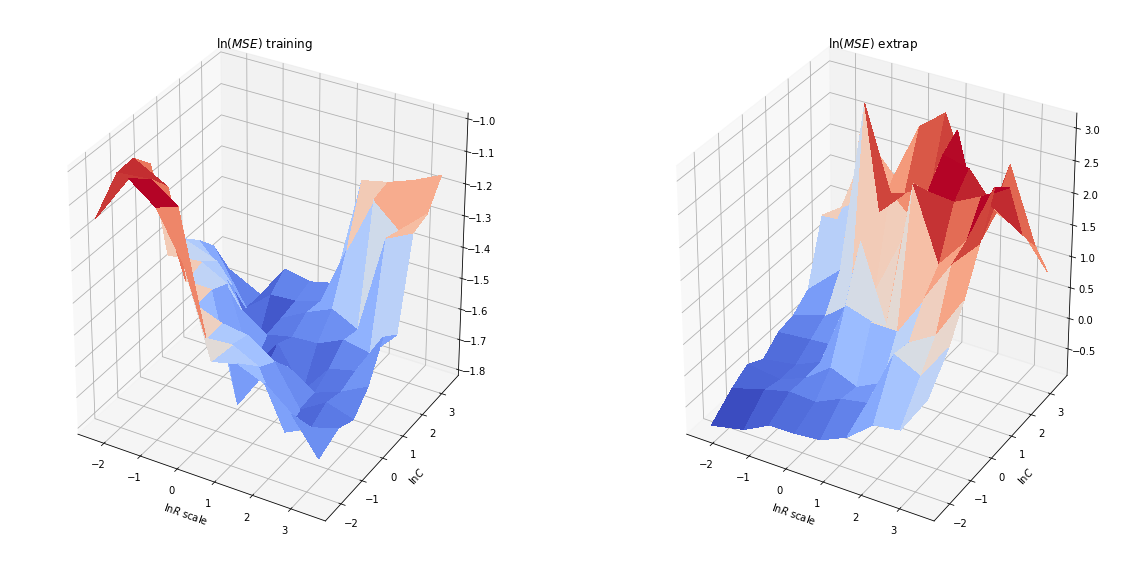

In [59]:
files = np.load('MSE_parameter_sweep_RC_ER_filterednoise_sin2.npz')

R_list = files['arr_0']
C_list = files['arr_1']
MSE_training_tuning = files['arr_2']
MSE_extrap_tuning = files['arr_3']

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(20, 10))

rr, cc = np.meshgrid(R_list, C_list)

ax = fig.add_subplot(121, projection='3d')
    
surf = ax.plot_surface(np.log(rr), np.log(cc), np.log(MSE_training_tuning.T), rstride=1, cstride=1,
                        cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel(r'$\ln R$ scale')

ax.set_ylabel(r'$\ln C$')
ax.set_title(r'$\ln(MSE)$ training' )
    
#ax.view_init(azim=90)
             
ax = fig.add_subplot(122, projection='3d')
    
surf = ax.plot_surface(np.log(rr), np.log(cc), np.log(MSE_extrap_tuning.T), rstride=1, cstride=1,
                        cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel(r'$\ln R$ scale')

ax.set_ylabel(r'$\ln C$')
ax.set_title(r'$\ln(MSE)$ extrap')
    
#ax.view_init(azim=90)